In [1]:
from __future__ import print_function,division,absolute_import
import tables
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
from keras.utils import to_categorical
from keras.models import model_from_json
from custom_layers import Conv1D_linearphaseType
from heartnet_v1 import reshape_folds

In [3]:
log_name = 'fold1_noFIR 2019-01-09 09:22:42.665400'
checkpoint_name = "/media/taufiq/Data1/heart_sound/models/fold1+compare 2018-05-05 17:04:36.995687/weights.0007-0.8148.hdf5"
min_epoch = 100
min_metric = .7
confidence_thresh = 0.2

foldname = 'fold1+compare'
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/'
model_dir = '/media/taufiq/Data1/heart_sound/models/'
log_dir = '/media/taufiq/Data1/heart_sound/logs/'

## Load Model from checkpoint

In [4]:
model_dir = checkpoint_name[:checkpoint_name.find('fold')]
log_name = checkpoint_name[checkpoint_name.find('fold'):checkpoint_name.find('weights')-1]
print(log_name)

fold1+compare 2018-05-05 17:04:36.995687


In [5]:
if os.path.isdir(model_dir+log_name):
    print("Model directory found")
    if os.path.isfile(os.path.join(model_dir+log_name,"model.json")):
        print("model.json found. Importing")
    else:
        raise ImportError("model.json not found")

Model directory found
model.json found. Importing


In [6]:
with open(os.path.join(model_dir+log_name,"model.json")) as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,'DCT1D':DCT1D})
model.load_weights(checkpoint_name)

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_1 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_2 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_3 (Conv1D_li (None, 2500, 1)      31          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_lin

## Load Data

In [286]:
############## Importing data ############
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[0, :]
val_parts = feat.root.val_parts[0, :]

############## Relabeling ################

for i in range(0, y_train.shape[0]):
    if y_train[i] == -1:
        y_train[i] = 0  ## Label 0 for normal 1 for abnormal
for i in range(0, y_val.shape[0]):
    if y_val[i] == -1:
        y_val[i] = 0

############# Parse Database names ########

train_files = []
for each in feat.root.train_files[:][0]:
    train_files.append(chr(each))
print(len(train_files))
val_files = []
for each in feat.root.val_files[:][0]:
    val_files.append(chr(each))
print(len(val_files))

################### Reshaping ############

x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

3283
515
(93942, 2500, 1)
(93942, 1)
(15511, 2500, 1)
(15511, 1)


In [287]:
start_idx = 0
drop_idx = []
for idx,s in enumerate(train_parts):
    if idx in excl1:
        drop_idx.append(np.r_[start_idx:start_idx + int(s)])
    start_idx = start_idx + int(s)
drop_idx = np.hstack(drop_idx)
np.delete(x_train,drop_idx,axis=0).shape

(93514, 2500, 1)

## Load Training and Validation Filenames

In [215]:
import matlab.engine
eng = matlab.engine.start_matlab()
fold1_filenames = eng.load(os.path.join(fold_dir,'fold1_filenames.mat'))
compare_filenames = eng.load(os.path.join(fold_dir,'compare_filenames.mat'))
eng.quit()

train_filenames = fold1_filenames['train_files']
train_filenames.extend(compare_filenames['train_files'])
val_filenames = fold1_filenames['val_files']
val_filenames.extend(compare_filenames['val_files'])
print("Filenames Loaded : Train files {} and Validation Files {}".format(len(train_filenames),len(val_filenames)))

Filenames Loaded : Train files 3283 and Validation Files 515


In [5]:
dfTrain = pd.DataFrame(train_filenames,columns={"filenames"})
dfVal = pd.DataFrame(val_filenames,columns={"filenames"})
dfTrain['dataset'] = train_files
dfVal['dataset'] = val_files
dfVal.head()

,filenames,dataset
0,a0156.wav,a
1,a0148.wav,a
2,a0099.wav,a
3,b0265.wav,b
4,b0319.wav,b


## Get true labels per recording and append 

In [6]:
true = []
start_idx = 0
y_val_cc = np.transpose(np.argmax(y_val, axis=-1))
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp_ = y_val_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfVal['true'] = true

true = []
start_idx = 0
y_train_cc = np.transpose(np.argmax(y_train, axis=-1))
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
    temp_ = y_train_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfTrain['true'] = true

## Append true labels and signal quality index

In [22]:
true = []
start_idx = 0
y_val_cc = feat.root.valY[1,:]
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp_ = y_val_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfVal['quality'] = true

true = []
start_idx = 0
y_train_cc = feat.root.trainY[1,:]
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
    temp_ = y_train_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfTrain['quality'] = true

true = []
start_idx = 0
y_val_cc = np.transpose(np.argmax(y_val, axis=-1))
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp_ = y_val_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfVal['true'] = true

true = []
start_idx = 0
y_train_cc = np.transpose(np.argmax(y_train, axis=-1))
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
    temp_ = y_train_cc[start_idx:start_idx + int(s) - 1]
    if (sum(temp_ == 0) > sum(temp_ == 1)):
        true.append(0)
    else:
        true.append(1)
    start_idx = start_idx + int(s)
dfTrain['true'] = true

## Load Model from log name


Given a log_name it scans through the directories and finds the best three weights considering Sensitivity, Specificity and Macc.

In [6]:
if os.path.isdir(model_dir+log_name):
    print("Model directory found")
    if os.path.isfile(os.path.join(model_dir+log_name,"model.json")):
        print("model.json found. Importing")
    else:
        raise ImportError("model.json not found")

with open(os.path.join(model_dir+log_name,"model.json")) as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json,{'Conv1D_linearphaseType':Conv1D_linearphaseType})
model.summary()

Model directory found
model.json found. Importing
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_type_1 (Conv (None, 2500, 1)      30          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_2 (Conv (None, 2500, 1)      30          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_3 (Conv (None, 2500, 1)      30          input_1[0][0]                    
___________________________________________________________

In [7]:
training_csv = os.path.join(log_dir+log_name,"training.csv")
df = pd.read_csv(training_csv)

In [8]:
sens_idx = df['val_sensitivity'][df.epoch>min_epoch][df.val_specificity>min_metric].idxmax()
spec_idx = df['val_specificity'][df.epoch>min_epoch][df.val_sensitivity>min_metric].idxmax()
macc_idx = df['val_macc'][df.epoch>min_epoch].idxmax()
val_idx = df['val_acc'][df.epoch>min_epoch].idxmax()


In [9]:
weights = dict()
weights['val_sensitivity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[sens_idx]+1,df.val_acc.iloc[sens_idx])
weights['val_specificity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[spec_idx]+1,df.val_acc.iloc[spec_idx])
weights['val_macc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[macc_idx]+1,df.val_acc.iloc[macc_idx])
weights['val_acc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[val_idx]+1,df.val_acc.iloc[val_idx])
print("Best Sensitivity model: {} \t\t{}".format(df.val_sensitivity.iloc[sens_idx],weights['val_sensitivity']))
print("Best Specificity model: {} \t\t{}".format(df.val_specificity.iloc[spec_idx],weights['val_specificity']))
print("Best Macc model: {} \t\t{}".format(df.val_macc.iloc[macc_idx],weights['val_macc']))
print("Best Val model: {} \t\t\t{}".format(df.val_acc.iloc[val_idx],weights['val_acc']))

Best Sensitivity model: 0.981707251227 		weights.0153-0.8958.hdf5
Best Specificity model: 0.92982450159 		weights.0129-0.8204.hdf5
Best Macc model: 0.913956579485 		weights.0194-0.8862.hdf5
Best Val model: 0.895839817507 			weights.0153-0.8958.hdf5


In [10]:
val_pred = dict()
test_pred = dict()

In [11]:
test_pred.keys()

[]

In [12]:
metric = 'val_macc'
checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
model.load_weights(checkpoint_name)
print("Checkpoint loaded:\n %s" % checkpoint_name)

Checkpoint loaded:
 /media/taufiq/Data1/heart_sound/models/fold1_noFIR 2019-01-09 09:22:42.665400/weights.0194-0.8862.hdf5


In [16]:
# interspeech test data
feat = loadmat('/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/interspeech_test.mat')
x_val = np.expand_dims(feat['testX'],axis=-1)
y_val = np.expand_dims(feat['testY'],axis=-1)
val_parts = np.hstack(feat['test_parts'])

['testY', 'testX', '__header__', '__globals__', 'test_parts', '__version__']

In [13]:
# Load test data and evaluate
feat = tables.open_file(fold_dir + 'comParE' + '.mat')
x_test = feat.root.testX[:]
test_parts = feat.root.test_parts[0,:]
x_test = np.transpose(x_test)
x_test = np.expand_dims(x_test,axis=-1)
x_val = feat.root.valX[:]
x_val = np.concatenate([x_val,feat.root.trainX[:]],axis=-1)
y_val = feat.root.valY[0,:]
y_val = np.concatenate([y_val,feat.root.trainY[0,:]],axis=0)
val_parts = feat.root.val_parts[0,:]
val_parts = np.concatenate([val_parts,feat.root.train_parts[0,:]],axis=0)
x_val = np.transpose(x_val)
x_val = np.expand_dims(x_val,axis=-1)
for i in range(0, y_val.shape[0]):
    if y_val[i] == 2:
        y_val[i] = 1

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 604, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1087, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 277, in H5F_super_read
    file signature not found

End of HDF5 error back trace

Unable to open/create file '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/interspeech_test.mat'

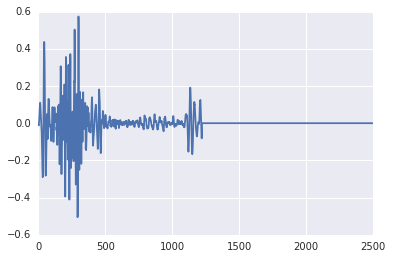

In [248]:
plt.plot(x_test[163])
plt.show()

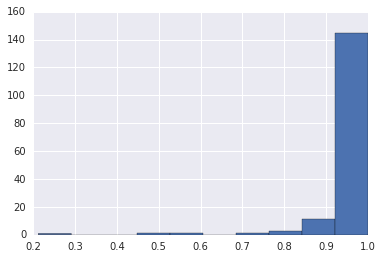

5


In [238]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions,axis=1)
start_idx=0
pred = []
for s in test_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp = sum(predictions[start_idx:start_idx + int(s)])/s
    pred.append(temp)
    start_idx = start_idx + int(s)
plt.hist(np.asarray(pred))
plt.show()
print(163 - sum(np.asarray(pred) > .8))
test_pred[metric]=pred
# with open('/media/taufiq/Data1/Heart_Sound/ComParE2018_Heartbeat_/testPred.csv','w') as fp:
#     for each in pred:
#         print(each)
#         if each > .8:
#             fp.write("1\n")
#         else:
#             fp.write("0\n")

In [29]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions,axis=1)
start_idx=0
true = []
pred = []
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    temp = sum(predictions[start_idx:start_idx + int(s)])/s
    pred.append(temp)
    temp = sum(y_val[start_idx:start_idx + int(s)])/s
    true.append(temp)
    start_idx = start_idx + int(s)
val_pred[metric] = pred

ResourceExhaustedError: OOM when allocating tensor with shape[32,1,1,2500] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv1d_linearphase_type_3/convolution/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1d_linearphase_type_3/convolution/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1d_linearphase_type_3/convolution/ExpandDims_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: dense_2/Softmax/_359 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_879_dense_2/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op u'conv1d_linearphase_type_3/convolution/Conv2D', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-5aa98f36a13c>", line 10, in <module>
    model = model_from_json(loaded_model_json,{'Conv1D_linearphaseType':Conv1D_linearphaseType})
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 379, in model_from_json
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/generic_utils.py", line 144, in deserialize_keras_object
    list(custom_objects.items())))
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2535, in from_config
    process_node(layer, node_data)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2492, in process_node
    layer(input_tensors[0], **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "custom_layers.py", line 521, in call
    dilation_rate=self.dilation_rate[0])
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 3303, in conv1d
    data_format=tf_data_format)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 193, in _conv1d
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/util/deprecation.py", line 497, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/util/deprecation.py", line 497, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 2464, in conv1d
    data_format=data_format)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,1,1,2500] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv1d_linearphase_type_3/convolution/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1d_linearphase_type_3/convolution/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1d_linearphase_type_3/convolution/ExpandDims_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: dense_2/Softmax/_359 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_879_dense_2/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [235]:
from sklearn.metrics import confusion_matrix
def threshMacc(true,pred):
        macc = []
        eps = 1e-09
        thresh = np.r_[0:1.:.01]
        for each in thresh:
            pred_thresh = np.asarray(pred) >= each
            TN, FP, FN, TP = confusion_matrix(true, pred_thresh, labels=[0,1]).ravel()
            sensitivity = TP / (TP + FN + eps)
            specificity = TN / (TN + FP + eps)
            macc.append((sensitivity+specificity)/2)
        return (np.asarray(macc),thresh)

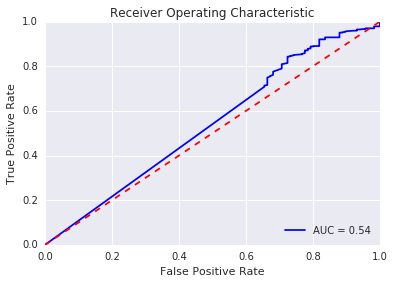

In [189]:
from sklearn.metrics import roc_curve, auc, accuracy_score
fpr, tpr, threshold = roc_curve(true, pred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

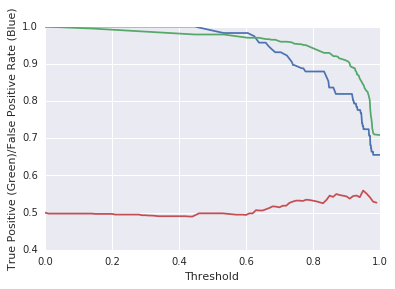

In [183]:
plt.plot(threshold[1:],fpr[1:])
plt.plot(threshold[1:],tpr[1:])
plt.plot(thresh,macc)
plt.ylabel('True Positive (Green)/False Positive Rate (Blue)')
plt.xlabel('Threshold')
plt.show()

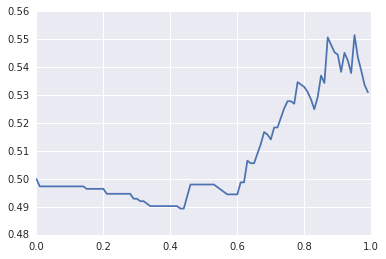

In [264]:
macc,thresh = threshMacc(true,np.max(np.vstack(val_pred.values()),axis=0))
plt.plot(thresh,macc)
plt.show()

In [263]:
np.max(np.vstack(val_pred.values()),axis=0)

(682,)

In [268]:
df = pd.DataFrame(test_pred)
df.to_csv('/media/taufiq/Data1/Heart_Sound/ComParE2018_Heartbeat_/testPred.csv',index=False)

## Get Validation Predictions, get per recording Confidence and append

In [42]:
y_pred = model.predict(x_val, verbose=1)
y_pred_hard = np.argmax(y_pred,axis=-1)
predicted_confidence = np.asarray([y_pred[i,j] for i,j in enumerate(y_val_cc)])
start_idx=0
pred = []
for s in val_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
    pred.append(temp)
    start_idx = start_idx + int(s)
dfVal['conf_'+metric]=pred
# plt.figure(figsize=(10,10))
# dfVal['conf_'+metric].hist(bins=20)
# plt.show()

15511/15511 [==============================] - 1s 96us/step


## Get Training Predictions, get per recording Confidence and append

In [43]:
y_pred = model.predict(x_train, verbose=1)
y_pred_hard = np.argmax(y_pred,axis=-1)
predicted_confidence = np.asarray([y_pred[i,j] for i,j in enumerate(y_train_cc)])
start_idx=0
pred = []
for s in train_parts:
    if not s:  ## for e00032 in validation0 there was no cardiac cycle
        continue
    # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
    temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
    pred.append(temp)
    start_idx = start_idx + int(s)
dfTrain['conf_'+metric]=pred
# plt.figure(figsize=(10,10))
# dfTrain['conf_'+metric].hist(bins=20)
# plt.show()

93942/93942 [==============================] - 9s 98us/step


In [ ]:
# plt.figure(figsize=(10,10))
# sns.distplot(dfTrain['conf_'+metric])
# plt.xlim(0,1)
# plt.show()

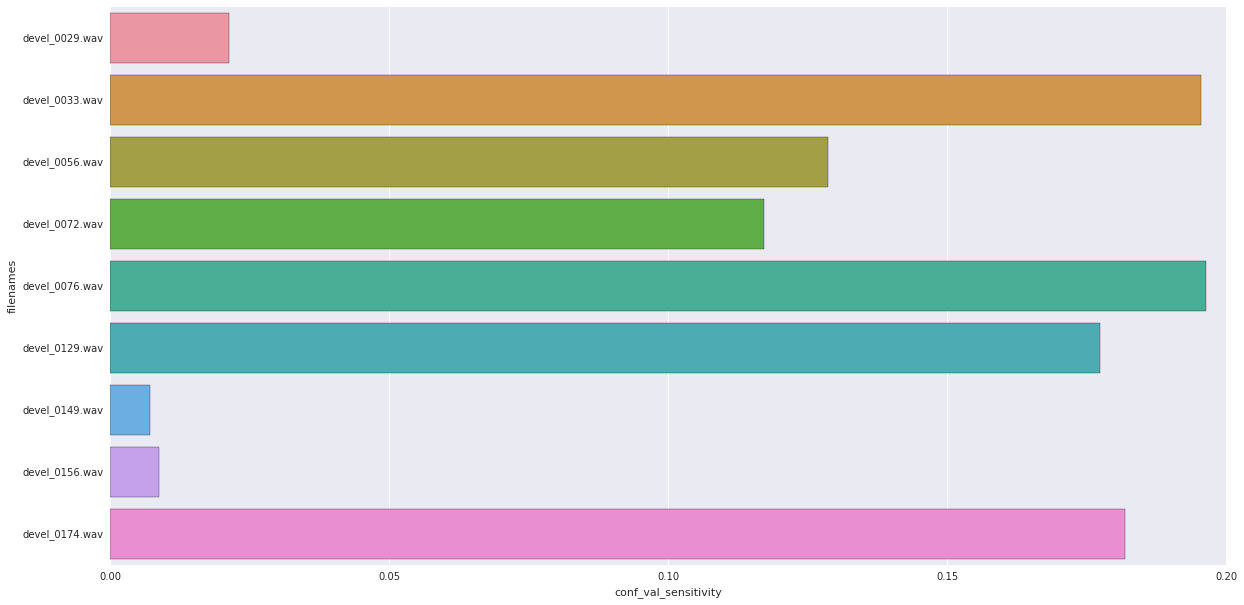

devel_0029.wav 1 1
devel_0033.wav 0 1
devel_0056.wav 1 1
devel_0072.wav 1 1
devel_0076.wav 1 1
devel_0129.wav 0 1
devel_0149.wav 0 1
devel_0156.wav 0 1
devel_0174.wav 0 1


In [51]:
plt.figure(figsize=(20,10))
mask = dfVal['conf_'+metric]<=confidence_thresh
sns.barplot(x=dfVal['conf_'+metric][mask],y=dfVal.filenames[mask])
plt.show()
for names in zip(dfVal.filenames[mask],dfVal.true[mask],dfVal.quality[mask]):
    print("%s %d %d" % names)

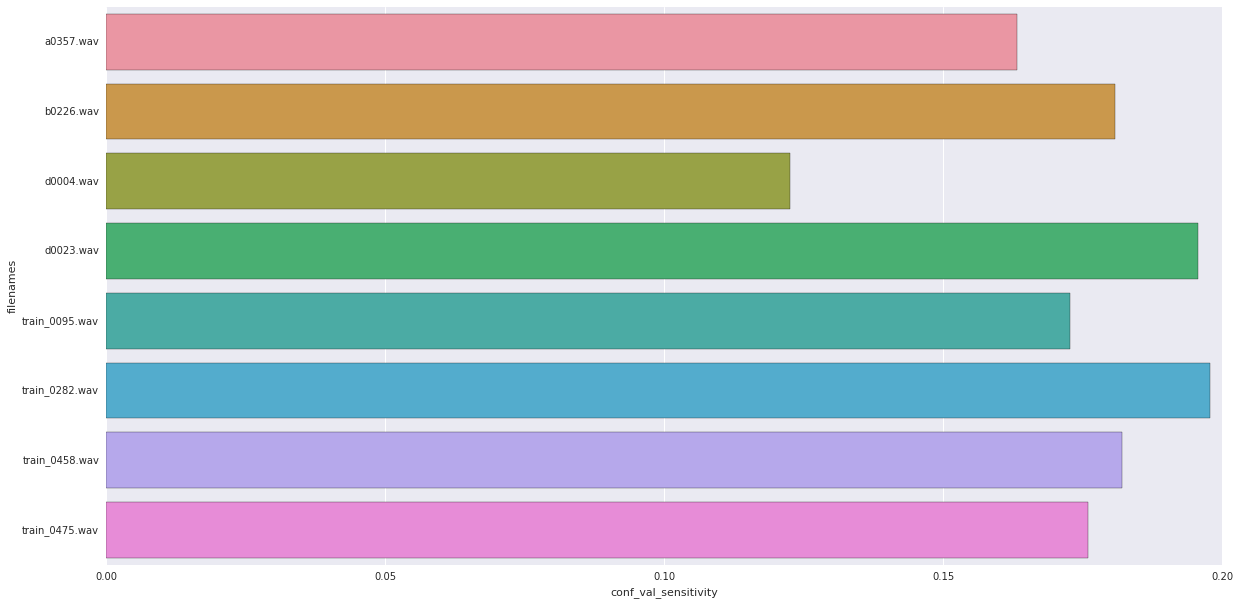

a0357.wav 1 1
b0226.wav 0 0
d0004.wav 1 1
d0023.wav 0 1
train_0095.wav 0 1
train_0282.wav 0 1
train_0458.wav 0 1
train_0475.wav 0 1


In [52]:
plt.figure(figsize=(20,10))
mask = dfTrain['conf_'+metric]<=confidence_thresh
sns.barplot(x=dfTrain['conf_'+metric][mask],y=dfTrain.filenames[mask])
plt.show()
for names in zip(dfTrain.filenames[mask],dfTrain.true[mask],dfTrain.quality[mask]):
    print("%s %d %d" % names)

## Find out the recordings that have huge fluctuations in confidence

In [47]:
for epoch in range(min_epoch,df.epoch.count()):
    checkpoint_name = os.path.join(model_dir+log_name,
                                   "weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch]))
    model.load_weights(checkpoint_name)
    y_pred = model.predict(x_train, verbose=1)
    y_pred_hard = np.argmax(y_pred,axis=-1)
    predicted_confidence = np.asarray([y_pred[i,j] for i,j in zip(range(len(y_pred)),np.nditer(y_train_cc))])
    start_idx=0
    pred = []
    for s in train_parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
        temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
        pred.append(temp)
        start_idx = start_idx + int(s)
    dfTrain["weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch])]=pred

93942/93942 [==============================] - 9s 95us/step


1
80
0
1
80
2
0


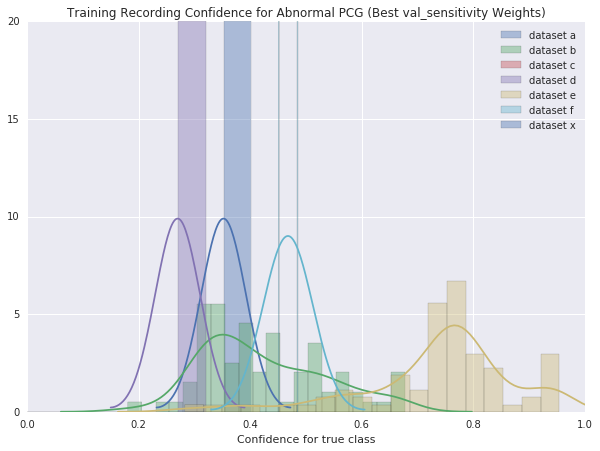

In [38]:
# list_sweep = dfTrain.columns[-(df.epoch.count()-min_epoch):] # list of columns for sweep
# plt.figure(figsize=(20,10))
# sns.boxplot(x="filenames",data=dfTrain[list_sweep.append("filenames")])
# plt.show()
# dfTrain['conf_mean'] = dfTrain[list(dfTrain.columns.values)[-100:]].mean(axis=1).values
# dfTrain['conf_var'] = dfTrain[list(dfTrain.columns.values)[-100:]].var(axis=1).values
metric = 'val_sensitivity'
plt.figure(figsize=(10,7))
for color,dataset in enumerate(dfTrain.dataset.unique()):
#     if dataset != 'f':
#         continue
#     sns.distplot(dfTrain['conf_'+metric][dfTrain.true == 1][dfTrain.dataset == dataset],bins=20,kde_kws={'bw':.04},label='Abnormal')
    sns.distplot(dfTrain['conf_'+metric][dfTrain.true == 0][dfTrain.dataset == dataset][dfTrain.quality == 0],bins=20,
                 kde_kws={'bw':.04},label='dataset '+dataset,
                )
    print(dfTrain['conf_'+metric][dfTrain.true == 0][dfTrain.dataset == dataset][dfTrain.quality == 0].count())
plt.legend()
plt.xlim([0,1])
plt.xlabel("Confidence for true class")
plt.title("Training Recording Confidence for Abnormal PCG (Best "+metric+" Weights)")
# plt.yscale('log')
plt.show()

Label 1 : Count 67
Label 0 : Count 164


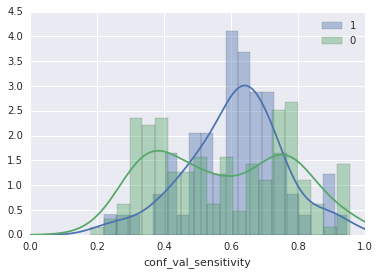

In [40]:
for true in dfTrain.true.unique():
    print ("Label %d : Count %d" % (true,dfTrain['conf_'+metric][dfTrain.true == true][dfTrain.quality == 0].count()))
    sns.distplot(dfTrain['conf_'+metric][dfTrain.true == true][dfTrain.quality == 0],bins=20,
#                      kde_kws={'bw':.04},
                     label=str(true)
                    )
plt.legend()
plt.xlim([0,1])
plt.show()

In [147]:
colors = {'a':'b','b':'g','c':'r','d':'c','e':'m','f':'y','x':'k'}
markers = ["x","o"]

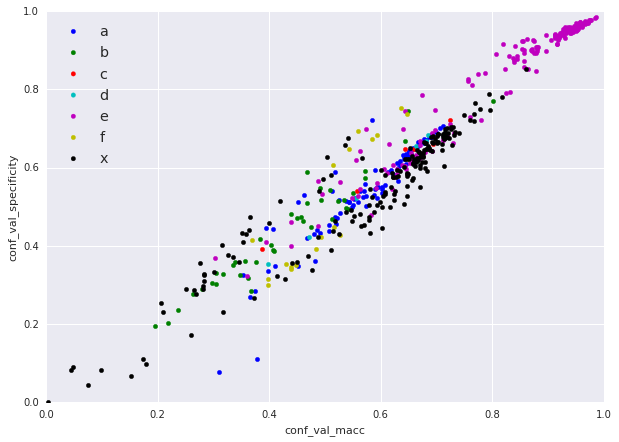

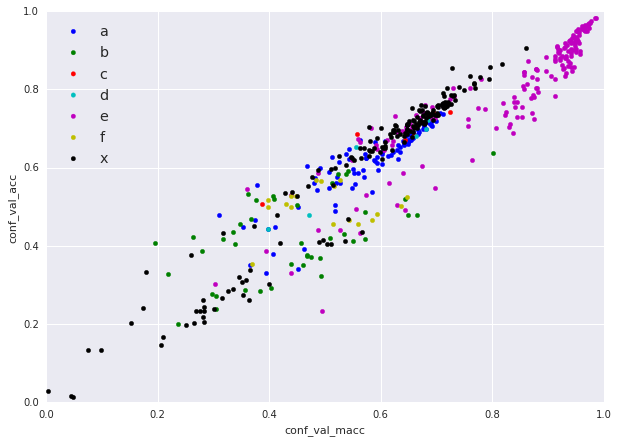

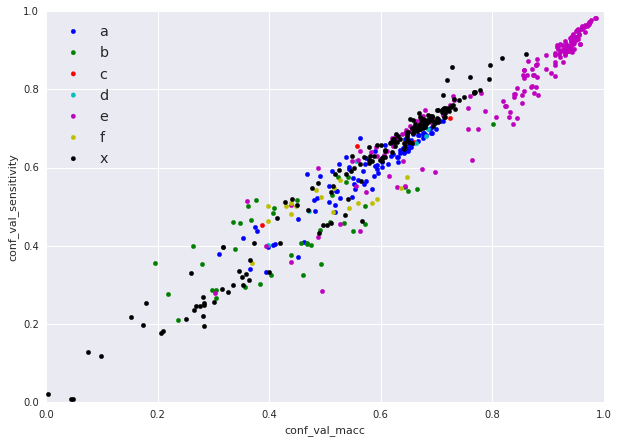

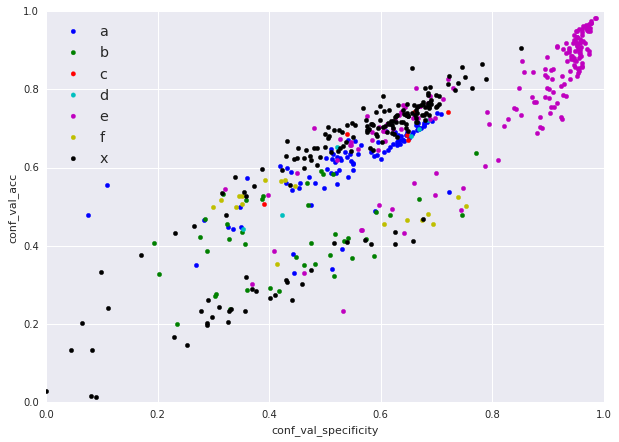

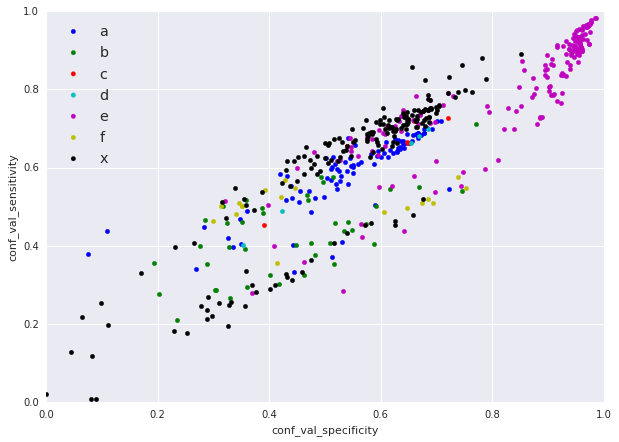

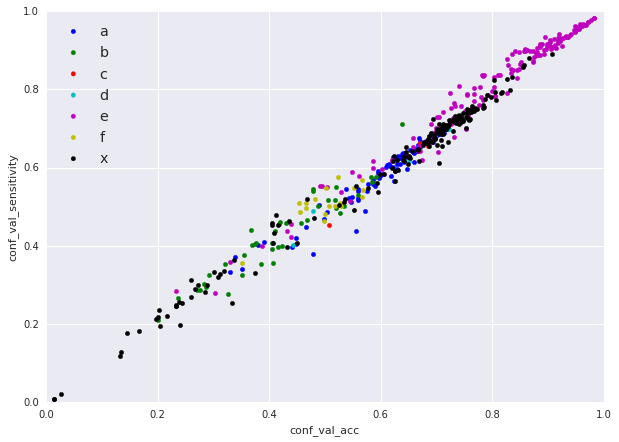

In [202]:
it = itertools.combinations(weights.keys(),2)
plt.figure(figsize=(10,7))
for each in it:
    for dataset in dfTrain.dataset.unique():
        plt.scatter(x=dfVal['conf_'+each[0]][dfVal.dataset == dataset],
                    y=dfVal['conf_'+each[1]][dfVal.dataset == dataset],
                    color=colors[dataset],
                    label=dataset,
                    marker="o",
#                     linewidth=
                   )
#     plt.scatter(x=dfTrain['conf_'+each[0]], y=dfTrain['conf_'+each[1]], color=[colors[dataset] for dataset in dfTrain['dataset']],marker="*")
    plt.xlabel('conf_'+each[0])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.ylabel('conf_'+each[1])
    plt.legend(loc=2,fontsize='large')
    plt.show()
    plt.figure(figsize=(10,7))

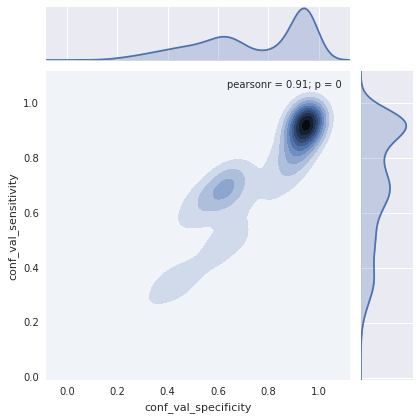

In [42]:
sns.jointplot(x=dfTrain['conf_val_specificity'], y=dfTrain['conf_val_sensitivity'], kind="kde")
plt.show()

# Visualize confidence distributions accross recordings

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Number of recordings 63


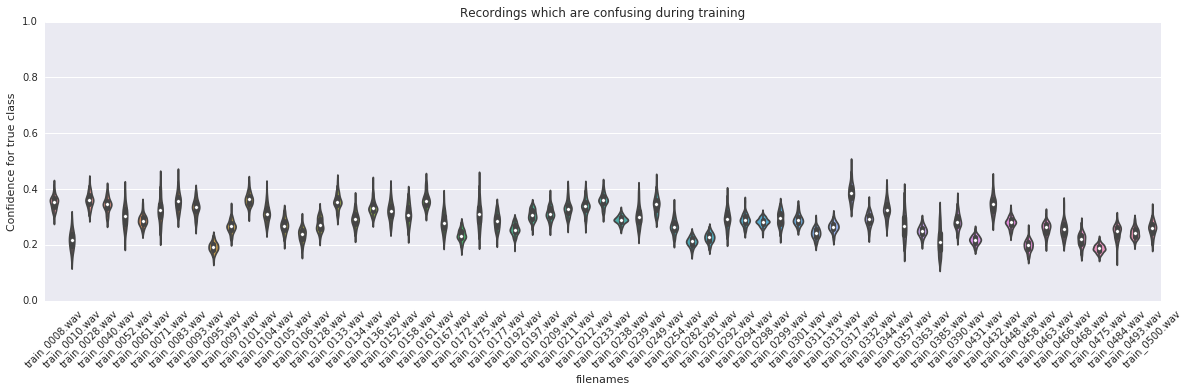

train_0008.wav
train_0010.wav
train_0028.wav
train_0040.wav
train_0052.wav
train_0061.wav
train_0071.wav
train_0083.wav
train_0093.wav
train_0095.wav
train_0097.wav
train_0101.wav
train_0104.wav
train_0105.wav
train_0106.wav
train_0128.wav
train_0133.wav
train_0134.wav
train_0136.wav
train_0152.wav
train_0158.wav
train_0161.wav
train_0167.wav
train_0172.wav
train_0175.wav
train_0177.wav
train_0192.wav
train_0197.wav
train_0209.wav
train_0211.wav
train_0212.wav
train_0233.wav
train_0238.wav
train_0239.wav
train_0249.wav
train_0254.wav
train_0282.wav
train_0291.wav
train_0292.wav
train_0294.wav
train_0298.wav
train_0299.wav
train_0301.wav
train_0311.wav
train_0313.wav
train_0317.wav
train_0332.wav
train_0344.wav
train_0357.wav
train_0363.wav
train_0385.wav
train_0390.wav
train_0431.wav
train_0432.wav
train_0448.wav
train_0458.wav
train_0463.wav
train_0466.wav
train_0468.wav
train_0475.wav
train_0484.wav
train_0493.wav
train_0500.wav


In [220]:
test = dfTrain[dfTrain.conf_mean < .4][dfTrain.conf_var < .002][dfTrain.dataset == 'x']
print("Number of recordings %d" % (test.count()[0]))
test.set_index("filenames",inplace=True)
test = test.transpose()
test = test.iloc[6:-2]
test.set_index(np.r_[0:test.count()[0]],inplace=True)
plt.figure(figsize=(20,5))
sns.violinplot(data=test,jitter=True)
plt.ylabel("Confidence for true class")
plt.title("Recordings which are confusing during training")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()
for names in test.columns.values:
    print("%s" % names)

In [183]:
for dataset in dfTrain.dataset.unique():
    for true in dfTrain.true.unique():
        test = dfTrain[dfTrain.conf_mean > .55][dfTrain.true == true][dfTrain.dataset == dataset].count()[0]
        print("%d" % (test))

170
24
17
83
17
1
12
0
109
1699
3
55
381
2


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


## Validation set inspection

In [78]:
for epoch in range(min_epoch,df.epoch.count()):
    checkpoint_name = os.path.join(model_dir+log_name,
                                   "weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch]))
    model.load_weights(checkpoint_name)
    y_pred = model.predict(x_val, verbose=1)
    y_pred_hard = np.argmax(y_pred,axis=-1)
    predicted_confidence = np.asarray([y_pred[i,j] for i,j in enumerate(y_val_cc)])
    start_idx=0
    pred = []
    for s in val_parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,star_idx,start_idx+int(s)-1)
        temp = sum(predicted_confidence[start_idx:start_idx + int(s) - 1])/s
        pred.append(temp)
        start_idx = start_idx + int(s)
    dfVal["weights.%.4d-%.4f.hdf5" % (epoch+1,df.val_acc.iloc[epoch])]=pred

15511/15511 [==============================] - 1s 94us/step


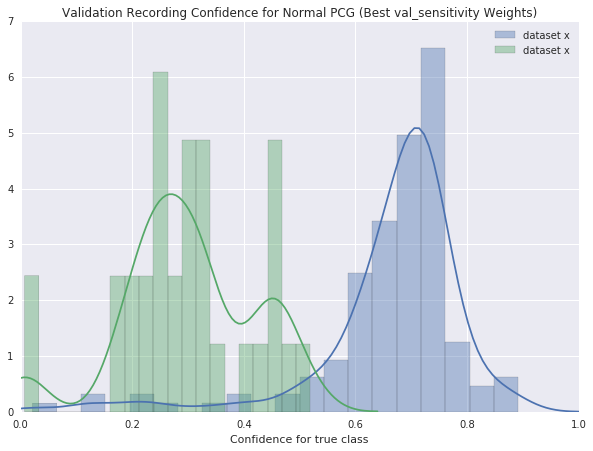

In [211]:
# dfVal['conf_mean'] = dfVal[list(dfVal.columns.values)[-100:]].mean(axis=1).values
# dfVal['conf_var'] = dfVal[list(dfVal.columns.values)[-100:]].var(axis=1).values
plt.figure(figsize=(10,7))
metric = 'val_sensitivity'
for dataset in dfTrain.dataset.unique():
#     sns.distplot(dfVal['conf_'+metric][dfVal.true == 1],bins=20,kde_kws={'bw':.04},label='Abnormal')
    if dataset != 'x':
        continue
    sns.distplot(dfVal['conf_'+metric][dfVal.true == 1][dfVal.dataset == dataset],bins=20,kde_kws={'bw':.04},label='dataset '+dataset)
    sns.distplot(dfVal['conf_'+metric][dfVal.true == 0][dfVal.dataset == dataset],bins=20,kde_kws={'bw':.04},label='dataset '+dataset)
plt.legend()
plt.xlim([0,1])
plt.xlabel("Confidence for true class")
plt.title("Validation Recording Confidence for Normal PCG (Best "+metric+" Weights)")
plt.show()

In [ ]:
dfTrain.to_csv('/media/taufiq/Data1/heart_sound/dfTrain.csv',index=None)
dfVal.to_csv('/media/taufiq/Data1/heart_sound/dfVal.csv',index=None)

In [5]:
dfTrain = pd.read_csv('/media/taufiq/Data1/heart_sound/dfTrain.csv')
dfVal = pd.read_csv('/media/taufiq/Data1/heart_sound/dfVal.csv')